![](http://)你好，我是七月在线fan:  
print("julyfedu")是为了防中断  
文档会不定期更新  
建议去kaggle fork运行代码，可以不用下载数据集和配置环境，还有免费的gpu。这篇kernel已被fan私有，其他人看不见，可以和群里的fan私聊,申请授权。  
有问题请指出！感谢！  
转载请注明出处  
这是原作者的kernel：  
https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai/  
这是这篇kernel的地址：  
https://www.kaggle.com/fanhaobei/a-complete-ml-pipeline/  
这是七月在线的网址：  
https://www.julyedu.com/

补充资料 One Page Knowledge   https://alexiej.github.io/deepnn/#gpu-servers

**Sections of this kernel这篇kernel的目录**
- Project understanding了解项目
- Data understanding了解数据
- Data visualization数据可视化
- Baseline model (Fastai v1)基准模型
- 训练  
- Validation and analysis验证和分析
    - Metrics 指标
    - Prediction and activation visualizations预测和热图可视化
    - ROC & AUC 指标
- Submit提交
- Deploy(example)部署

<center>Section: Data visualization数据可视化(第一行是正常的，第二行是有癌的)</center>
<div align=center>
<a href="https://ibb.co/5Mpm3ZF"><img src="https://i.ibb.co/gjqN8YV/metastases.png" alt="metastases" width="1400" hegiht="400" border="0" align="center"></a></div>   
<br>
<br>
<br>
<br>
<br>
<br>
<center>Section: Prediction and activation visualizations预测和热图可视化  
    (第一行是随机取样，第二行是最错误的，第三行是最正确的。预测类别/真实类别/损失值/概率)</center>
<div align=center>
<a href="https://ibb.co/Pc6wbyk"><img src="https://i.ibb.co/sKVyD47/gradcam.png" alt="gradcam" width="1800" hegiht="400" border="0"></a></div>

# 1.Project understanding了解项目
##  What exactly is the problem?问题是什么？

**Binary image classification problem.图像二分类问题** Identify the presence of metastases from 96 x 96px digital histopathology images. One key challenge is that the metastases can be as small as single cells in a large area of tissue.  
判断96 x 96像素的数字组织病理学彩色图像中转移癌细胞的存在。一个关键的挑战是转移癌细胞非常小。

## 业务场景  

本次的PatchCamelyon（PCam）数据集来自Camelyon16 Challenge。
Google发的一篇科技博客Assisting Pathologists in Detecting Cancer with Deep Learning，主要内容讲的是针对病理图像中乳腺癌在淋巴结中的转移的检测任务。这篇文章的背景是医学顶级会议ISBI在2016年发布的Camelyon16的竞赛，竞赛的主要内容是对乳腺癌在淋巴结中的转移进行病理切片的分类与定位。  
一般来说，乳腺癌细胞的扩散方式通常会首先转移到附近的淋巴结中，所以在很多乳腺检查中，会提取一些附近淋巴结组织做成切片，经过切片、染色、扫描等过程后，生成如上图的图像。癌细胞和正常细胞在颜色、纹理、大小和组织形式上都会有很多的不同，一般来说就是“核大深染”的突出特征。在大医院中，很多上了年纪的且具有很多“看片”经验的医生炙手可热，这意味着人类同样需要很多经验才能正确的进行分析判断，而年轻的或缺乏经验的医生容易出现误判。Camelyon16希望我们能够通过计算机视觉技术帮助医生进行有效筛选，从而减少工作量和误判的可能性。  
Camelyon16的任务是对测试集中的120张淋巴结病理切片进行判断是否发生了癌变(classification)，同时需要对发生癌变的位置区域精准定位(segmentation)；而Camelyon17的任务变得更加复杂，在16的基础上需要对发生癌变转移的区域进行大小判断，从而将病理切片分为Normal/ITC/Micro/Macro四个类别，最终根据每个病人的五张切片的定性结果确定病人的乳腺癌细胞转移的情况。  

摘自：  
https://github.com/basveeling/pcam#benchmark  
https://blog.csdn.net/c2a2o2/article/details/76151311  
https://camelyon16.grand-challenge.org/  
CAMELYON16 Overview  
The goal of this challenge is to evaluate new and existing algorithms for automated detection of metastases in hematoxylin and eosin (H&E) stained whole-slide images of lymph node sections. This task has a high clinical relevance but requires large amounts of reading time from pathologists. Therefore, a successful solution would hold great promise to reduce the workload of the pathologists while at the same time reduce the subjectivity in diagnosis. This will be the first challenge using whole-slide images in histopathology. The challenge will run for two years. The 2016 challenge will focus on sentinel lymph nodes of breast cancer patients and will provide a large dataset from both the Radboud University Medical Center (Nijmegen, the Netherlands), as well as the University Medical Center Utrecht (Utrecht, the Netherlands).  


## How would a solution look like?评测指标？

**Our evaluation metric is [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic).** The ROC curve is a plot of *True positive rate* against *False positive rate* at various thresholds and the area under the curve (AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. The best possible solution would yield an AUC of 1 which means we would classify all positive samples correctly without getting any false positives.   
我们的评估指标是ROC曲线下面积.ROC曲线是不同阈值下的真正例率与假正例率的曲线图，曲线下面积（AUC）等于分类器对概率排序后 正例高于反例的比例。AUC最理想的值为1，这意味着我们将正确地对所有正例进行分类而没有将任何反例当做正例。  

![ROC curve 曲线下面积example](https://i.ibb.co/mBKh6ZB/roc.png)
<p style="text-align: center;"> ROC curve from a previous run of this kernel这篇kernel的ROC曲线 </p>

## What is known about the domain?专业领域知识？

**The histopathological images are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin (H&E).** This staining method is one of the most widely used in medical diagnosis and it produces blue, violet and red colors. Dark blue hematoxylin binds to negatively charged substances such as nucleic acids and pink eosin to positively charged substances like amino-acid side chains (most proteins). Typically nuclei are stained blue, whereas cytoplasm and extracellular parts in various shades of pink.  
**组织病理学图像是用苏木精和伊红（H＆E）染色的淋巴结的玻璃载玻片显微镜图像。**这种染色方法是医学诊断中最广泛使用的方法之一，它产生蓝色，紫色和红色。 深蓝苏木精与带负电荷的物质（如核酸和粉红素）结合到带正电荷的物质如氨基酸侧链（大多数蛋白质）。 通常，细胞核染成蓝色，而细胞质和细胞外部分染成各种粉红色。  

**Low-resolution低分辨率**             | **Mid-resolution中等分辨率**            | **High-resolution高分辨率** 
:-------------------------:|:-------------------------:|:-------------------------:
![](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_low_resolution.png) | ![Example of a metastatic region转移癌例子](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_mid_resolution.png) | ![Example of a metastatic region转移癌例子](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_high_resolution.png)
**[<p style="text-align: center;"> Example of a metastatic region in lymph nodes淋巴结转移癌区域的例子, CHAMELYON17 </p>](https://camelyon17.grand-challenge.org/Background/)**

Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer. The diagnostic procedure for pathologists is tedious and time-consuming as a large area of tissue has to be examined and small metastases can be easily missed.  
淋巴结是小腺体，可过滤淋巴系统中的液体，它们是乳腺癌可能传播的第一个位置。 淋巴结转移的组织学评估是TNM分类中确定乳腺癌分期的一部分，TNM分类是用于分类癌症扩散程度的全球公认标准。 病理学家的诊断程序繁琐且耗时，因为必须检查大面积的组织并且很容易错过小的转移癌细胞。  

**Useful links for background knowledge参考链接**
- [Patch Camelyon (PCam)](https://github.com/basveeling/pcam)
- [Hematoxylin and eosin staining of tissue and cell sections](https://www.ncbi.nlm.nih.gov/pubmed/21356829)
- [H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset](https://academic.oup.com/gigascience/article/7/6/giy065/5026175)
- [CAMELYON16 - background](https://camelyon16.grand-challenge.org/Background/)
- [CAMELYON17 - background](https://camelyon17.grand-challenge.org/Background/)
- [TNM classification](https://www.uicc.org/resources/tnm)

# 2.Data understanding了解数据
## What data do we have available?我们有哪些数据？  

**220k training images and 57k evaluation images.** The dataset is a subset of the [PCam dataset](https://github.com/basveeling/pcam) and the only difference between these two is that all duplicate images have been removed. The PCam dataset is derived from the [Camelyon16 Challenge dataset](https://camelyon16.grand-challenge.org/Data/) which contains 400 H&E stained whole slide images of sentinel lymph node sections that were acquired and digitized at 2 different centers using a 40x objective. The PCam's dataset including this one uses 10x undersampling to increase the field of view, which gives the resultant pixel resolution of 2.43 microns.  
220k训练图像和57k评估图像。数据集是PCam数据集的子集，这两者之间的唯一区别是所有重复的图像都已被删除。PCam数据集来自Camelyon16 Challenge数据集，其中包含400个H＆E染色标记的淋巴结切片的整个载玻片图像，使用40倍物镜在2个不同的中心采集和数字化。PCam的数据集（包括此数据集）使用10倍欠采样来增加视场，从而得到2.43微米的最终像素分辨率。  


According to the data description, there is a 50/50 balance between positive and negative examples in the training and test splits. However, **the training distribution seems to be 60/40 (negatives/positives)**. A positive label means that there is at least one pixel of tumor tissue in the center region (32 x 32px) of the image. **Tumor tissue in the outer region of the patch does not influence the label.** This means that a negatively labeled image could contain metastases in the outer region. Thus, it would be a good idea to crop the images to the center region.  
根据数据描述，训练和测试集中的正例和反例之间存在50/50的平衡。 但是，**训练数据的分布似乎是60/40（负数/正数）**。 <font color='blue'>正例标记意味着在图像的中心区域（32×32像素）中存在至少一个肿瘤组织像素</font>。 **贴片外部区域的肿瘤组织不会影响最后的标签。**这意味着反例标记的图像(中心没有肿瘤细胞)可能外部区域包含转移癌细胞。因此，将图像裁剪到中心区域是个好主意。  


**Image file descriptors图像文件的描述**

Description |  -
:--------:|:-------:
Format(格式) | TIF
Size(尺寸) | 96 x 96
Channels(通道数) | 3
Bits per channel(每个通道的比特数) | 8
Data type(数据类型) | Unsigned char
Compression(压缩方式) | Jpeg

## Is the data relevant to the problem?数据是否与问题相关？  

This dataset is a combination of two independent datasets collected in Radboud University Medical Center (Nijmegen, the Netherlands), and the University Medical Center Utrecht (Utrecht, the Netherlands). The slides are produced by routine clinical practices and a trained pathologist would examine similar images for identifying metastases. However, some relevant information about the surroundings might be left out with these small-sized image samples.  
该数据集是在Radboud大学医学中心（荷兰奈梅亨）和乌得勒支大学医学中心（荷兰乌得勒支）收集的两个独立数据集的组合。 幻灯片通过常规临床实践产生，并且训练有素的病理学家将检查用于识别转移癌的类似图像。 但是，这些小尺寸图像样本可能会遗漏一些有关周围环境的相关信息。

## Is it valid? Does it reflect our expectations?数据有效吗？ 它是否反映了我们的期望？

According to the data description, the dataset has been stripped of duplicates. However, this has not been confirmed by testing.  
根据数据描述，数据集已被删除重复数据。 但是，经过测试不能证实这一点。  

> For the entire dataset, when the slide-level label was unclear during the inspection of the H&E-stained slide, an additional WSI with a consecutive tissue section, immunohistochemically stained for cytokeratin, was used to confirm the classification.  
对于整个数据集，当在检查H＆E染色的载玻片期间载玻片水平标记不清楚时，使用具有连续组织切片的额外WSI，对细胞角蛋白进行免疫组织化学染色，以确认分类。  
- [1399 H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset(1399 H＆E染色乳腺癌患者的标记淋巴结切片：CAMELYON数据集)](https://academic.oup.com/gigascience/article/7/6/giy065/5026175)

## Is the data quality, quantity, recency sufficient?数据的质量、数量、新近度是否足够？  

> All glass slides included in the CAMELYON dataset were part of routine clinical care and are thus of diagnostic quality. However, during the acquisition process, scanning can fail or result in out-of-focus images. As a quality-control measure, all slides were inspected manually after scanning. The inspection was performed by an experienced technician (Q.M. and N.S. for UMCU, M.H. or R.vd.L. for the other centers) to assess the quality of the scan; when in doubt, a pathologist was consulted on whether scanning issues might affect diagnosis.  
CAMELYON数据集中包含的所有载玻片均为常规临床护理的一部分，因此具有诊断质量。 但是，在采集过程中，扫描可能会失败或图像失焦。 作为质量控制措施，扫描后手动检查所有载玻片。 检查由经验丰富的技术人员（Q.M.和N.S.为UMCU，M.H。或R.vd.L.为其他中心）进行，以评估扫描质量; 如有疑问，请咨询病理学家，了解扫描问题是否会影响诊断。  
- [1399 H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset](https://academic.oup.com/gigascience/article/7/6/giy065/5026175)

-----------------------------------------
# 3Data visualization数据可视化 、分析、预处理

In [92]:
import numpy as np #矩阵运算
import pandas as pd  # 数据分析和处理
import os #os模块负责程序与操作系统的交互，提供了访问操作系统底层的接口
import cv2 #opencv 图像预处理
import matplotlib.pyplot as plt #画图
import matplotlib.patches as patches #生成常见图形对象如：矩形，椭圆，圆形，多边形
import random #生成随机变量
from sklearn.utils import shuffle #洗牌：某个集合的随机排列组合
from tqdm import tqdm_notebook #进度条
import h5py

data = pd.read_csv('/home/julyedu_465286/histo/train_labels.csv') #读取csv文件转化为pandas dataframe
train_path = '/home/julyedu_465286/histo/' #训练集路径
test_path = '/home/julyedu_465286/histo/' #测试集路径
# quick look at the label stats # 快速查看标记的状态
data['label'].value_counts() #pd.Series.value_counts()  统计data['label']这个series的每种值的个数

0    130908
1     89117
Name: label, dtype: int64

In [16]:
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


We can see that the negative/positive ratio is not entirely 50/50 as there are 130k negatives and 90k negatives. The ratio is closer to 60/40 meaning that there are 1.5 times more negative images than positives.  
我们可以看到负实例/正实例比率不完全是50/50，实际有130k的负实例和90k的正实例。 该比率接近60/40，这意味着负实例的数量是正实例数量的1.5倍。

## Plot some images with and without cancer tissue for comparison 画出一些有癌组织和没有癌组织的图像进行比较

In [4]:
def readImage(path):
    # OpenCV reads the image in bgr format by default   OpenCV默认以bgr格式读取图像，path是图像的地址
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes   我们将图片翻转为rgb格式用于观看
    # cv2.split函数分离得到各个通道的灰度值(单通道图像)  https://blog.csdn.net/eric_pycv/article/details/72887758
    b,g,r = cv2.split(bgr_img)
    # cv2.merge函数是合并单通道成多通道（不能合并多个多通道图像） 
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

In [93]:

import h5py
f=h5py.File(os.path.join(train_path,'histro_train.h5'))
print(f['train_labels7'].shape[0])
dic={}
for i in range(1,21):
    tmp=f'train_labels{i}'
    dic[tmp]=f[tmp].shape[0]
print(dic)

11001
{'train_labels1': 10998, 'train_labels2': 11005, 'train_labels3': 11002, 'train_labels4': 11006, 'train_labels5': 11006, 'train_labels6': 10988, 'train_labels7': 11001, 'train_labels8': 10984, 'train_labels9': 11001, 'train_labels10': 11010, 'train_labels11': 11005, 'train_labels12': 10991, 'train_labels13': 10984, 'train_labels14': 11005, 'train_labels15': 11006, 'train_labels16': 11016, 'train_labels17': 10996, 'train_labels18': 11005, 'train_labels19': 11000, 'train_labels20': 11016}


In [60]:
f.close()

In [94]:
shuffled_data = shuffle(range(f['train_labels7'].shape[0])) 
# print(shuffled_data)
n=0
pdata,ndata=[],[]
while n<100:
    if f['train_labels7'][shuffled_data[n]][0]==b'0':
        pdata.append(shuffled_data[n])
    else:
        ndata.append(shuffled_data[n])
    n+=1
print(pdata,ndata)

[6170, 10743, 9773, 3435, 5769, 6322, 6713, 4603, 8314, 4538, 6778, 2620, 4445, 10745, 6561, 6035, 9505, 2025, 9764, 7014, 5630, 2444, 3562, 1484, 5600, 609, 10700, 4458, 7383, 2293, 4214, 4119, 8843, 8116, 7281, 286, 1694, 4024, 2698, 3900, 946] [7657, 770, 4087, 9101, 5081, 4176, 1710, 1650, 8705, 4924, 4497, 9511, 9889, 2898, 7825, 3734, 3533, 905, 6310, 8178, 6280, 6013, 522, 8312, 4071, 1023, 9568, 5648, 7574, 8540, 8523, 9472, 3505, 3011, 3401, 5671, 3963, 258, 10300, 9117, 3982, 10054, 7100, 4288, 9573, 8951, 10938, 359, 6061, 8712, 3746, 7307, 351, 50, 8573, 3669, 10814, 3629, 9353]


In [95]:
print(pdata,ndata)

[6170, 10743, 9773, 3435, 5769, 6322, 6713, 4603, 8314, 4538, 6778, 2620, 4445, 10745, 6561, 6035, 9505, 2025, 9764, 7014, 5630, 2444, 3562, 1484, 5600, 609, 10700, 4458, 7383, 2293, 4214, 4119, 8843, 8116, 7281, 286, 1694, 4024, 2698, 3900, 946] [7657, 770, 4087, 9101, 5081, 4176, 1710, 1650, 8705, 4924, 4497, 9511, 9889, 2898, 7825, 3734, 3533, 905, 6310, 8178, 6280, 6013, 522, 8312, 4071, 1023, 9568, 5648, 7574, 8540, 8523, 9472, 3505, 3011, 3401, 5671, 3963, 258, 10300, 9117, 3982, 10054, 7100, 4288, 9573, 8951, 10938, 359, 6061, 8712, 3746, 7307, 351, 50, 8573, 3669, 10814, 3629, 9353]


In [96]:
from matplotlib.font_manager import *  
myfont = FontProperties(fname='/home/julyedu_465286/simhei.ttf') 

Text(0,0.5,'Tumor tissue samples(positive)')

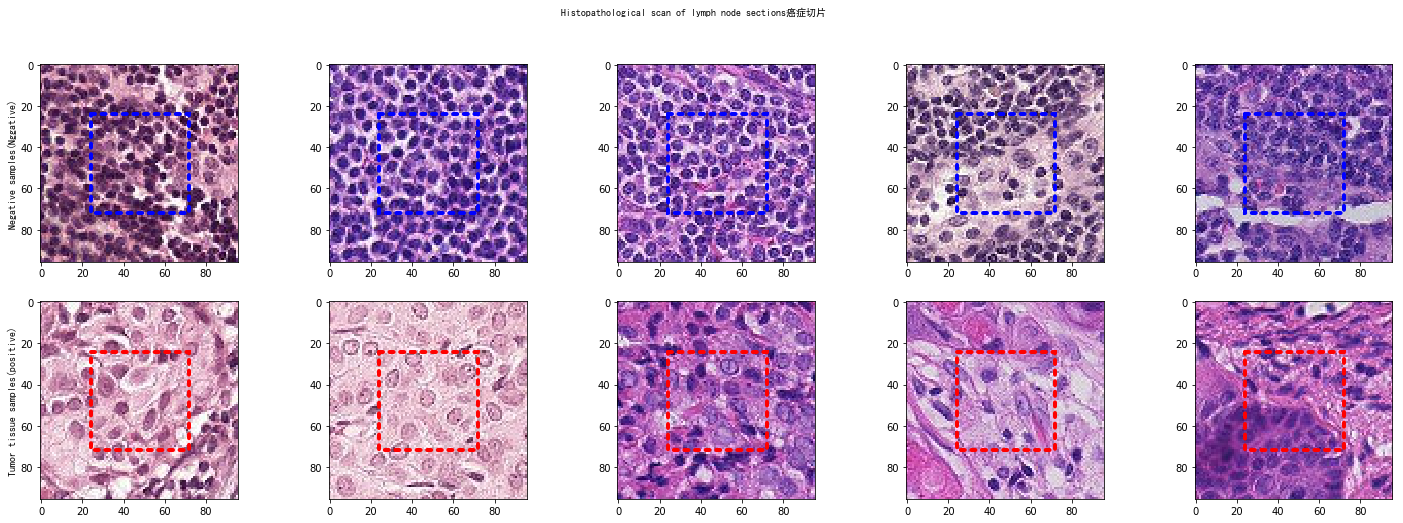

In [9]:

# matpoltlib subplots :创建一系列的子图  第一个参数nrows子图行的个数2，第二个参数ncols子图列的个数5 ,figsize画布尺寸, axes子图的轴， fig图
fig, ax = plt.subplots(2,5, figsize=(25,8))
# 标题  fontproperties=myfont使用中文字体
fig.suptitle('Histopathological scan of lymph node sections癌症切片',fontsize=30,fontproperties=myfont)

# 展示Negatives反例(没有转移癌)
for i in range(5): 
    # idx是随机排列的前五个反例的图片名，i是0~4
    # shuffled_data[shuffled_data['label'] == 0]   pandas布尔索引
    ax[0,i].imshow(f['train_images7'][ndata[i]])
#     path = os.path.join(train_path, idx) # 将训练集路径与反例图片名 拼接起来
#     ax[0,i].imshow(readImage(path + '.tif')) # 在坐标为[0,i]的轴上画出这张反例图
    # Create a Rectangle patch # 设计蓝色中心虚线矩形框
    box = patches.Rectangle((24,24),48,48,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box) # 在坐标为[0,i]的轴上画出这个矩形框
ax[0,0].set_ylabel('Negative samples(Nggative)', size='large',fontproperties=myfont) # 给坐标为[0,0]的轴画出其y轴标题



# 展示Positives正例(有转移癌)
for i in range(5): # idx是随机排列的前五个正例的图片名，i是0~4的索引
#     path = os.path.join(train_path, idx) # 将训练集路径与正例图片名 拼接起来
#     ax[1,i].imshow(readImage(path + '.tif'))  # 在坐标为[1,i]的轴上画出这张正例图
    ax[1,i].imshow(f['train_images7'][pdata[i]])
    # Create a Rectangle patch # 设计红色中心虚线矩形框
    box = patches.Rectangle((24,24),48,48,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box) # 在坐标为[0,i]的轴上画出这个矩形框
ax[1,0].set_ylabel("Tumor tissue samples(positive)", size='large',fontproperties=myfont) # 给坐标为[1,0]的轴画出其y轴标题

In [10]:
def center_crop(x, center_crop_size):
    centerw, centerh = x.shape[0] // 2, x.shape[1] // 2
    halfw, halfh = center_crop_size[0] // 2, center_crop_size[1] // 2
    cropped = x[centerw - halfw : centerw + halfw,
                 centerh - halfh : centerh + halfh, :]
    return cropped

Text(0,0.5,'Tumor tissue samples(positive)')

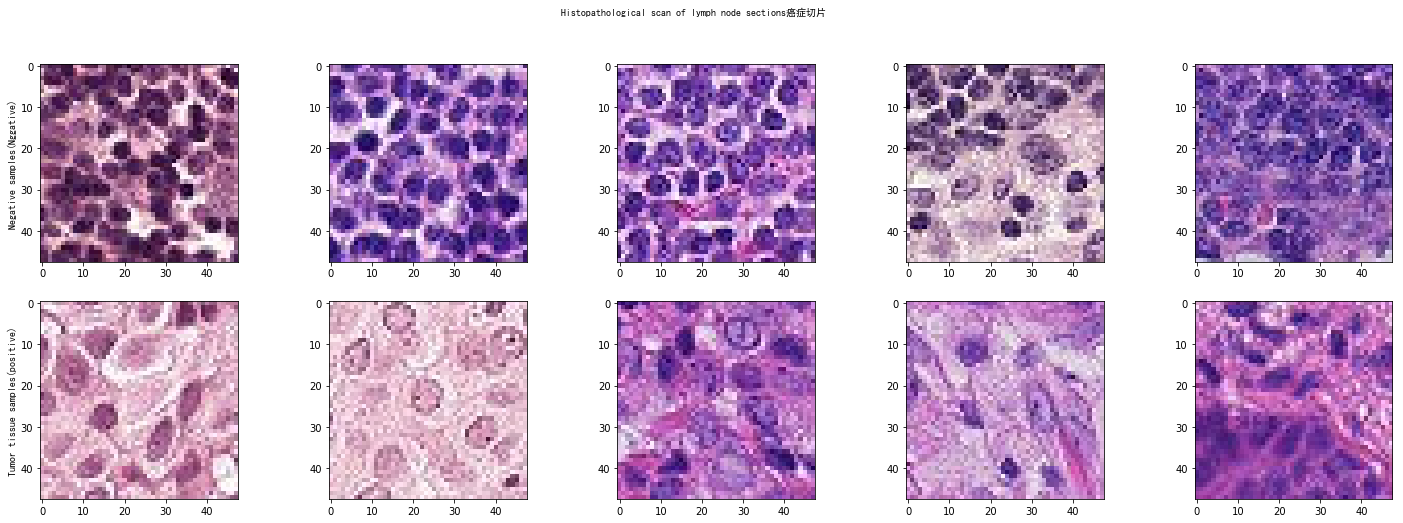

In [14]:
fig, ax = plt.subplots(2,5, figsize=(25,8))
fig.suptitle('Histopathological scan of lymph node sections癌症切片',fontsize=30,fontproperties=myfont)
for i in range(5): 
    ax[0,i].imshow(center_crop(f['train_images7'][ndata[i]],(48,48)))
ax[0,0].set_ylabel('Negative samples(Nggative)', size='large',fontproperties=myfont) # 给坐标为[0,0]的轴画出其y轴标题
for i in range(5): # idx是随机排列的前五个正例的图片名，i是0~4的索引
    ax[1,i].imshow(center_crop(f['train_images7'][pdata[i]],(48,48)))
ax[1,0].set_ylabel("Tumor tissue samples(positive)", size='large',fontproperties=myfont) # 给坐标为[1,0]的轴画出其y轴标题

Classifying metastases is probably not an easy task for a trained pathologist and extremely difficult for an untrained eye. According to [Libre Pathology](https://librepathology.org/wiki/Lymph_node_metastasis), lymph node metastases can have these features:  
对于训练有素的病理学家来说，转移癌分类可能不是一件容易的事，而对于未经训练的人来说则非常困难。根据Libre病理学，淋巴结转移癌细胞具有以下特征：

> - Foreign cell population - key feature (Classic location: subcapsular sinuses)外来细胞群 - 关键特征（经典位置：包膜下窦）
- Cells with cytologic features of malignancy具有恶性肿瘤细胞学特征的细胞
    - Nuclear pleomorphism (variation in size, shape and staining).核多形性（大小，形状和染色的变化）
    - Nuclear atypia:核非典型：
        - **Nuclear enlargement核扩大**.
        - **Irregular nuclear membrane核膜不规则**.
        - **Irregular chromatin pattern, esp. asymmetry不规则的染色质模式，尤其是不对称**.
        - **Large or irregular nucleolus大或不规则的核仁*.
     - Abundant mitotic figures丰富的有丝分裂
- Cells in architectural arrangements seen in malignancy; highly variable - dependent on tumour type and differentiation在恶性肿瘤中看到的结构中的细胞;高度可变 - 依赖于肿瘤类型和分化
    - Gland formation.腺体形成
    - Single cells.单细胞
    - Small clusters of cells.小细胞群
  
**The takeaway from this is probably that irregular nuclear shapes, sizes or staining shades can indicate metastases.这可能是由于不规则的核形状，大小或染色阴影可能表明转移癌**

## How is the data best transformed for modeling?如何最好地为建模转换数据？

We know that the label of the image is influenced only by the center region (32 x 32px) so it would make sense to crop our data to that region only. However, some useful information about the surroundings could be lost if we crop too close.  This hypothesis could be confirmed by training models with varying crop sizes. My initial results with 32 x 32px size showed worse performance than with 48 x 48px but I haven't done a search for optimal size.  
<font color= 'blue'>
我们知道图像的标签仅受中心区域（32 x 32px）的影响，因此将数据裁剪到该区域是有意义的。但是，如果我们收得太近，一些关于周围环境的有用信息可能会丢失。这种假设可以通过具有不同切割大小的训练模型来确认</font>。我的初始结果是32 x 32px尺寸表现出比48 x 48px更差的性能，但我还没有寻找最佳尺寸。  

## How may we increase the data quality?我们如何提高数据质量？

We could inspect if the  
我们可以检查数据是否包含错误数据（未聚焦或损坏的图片）并删除这些数据以提高整体质量。

## Preprocessing and augmentation 预处理和数据增强
There are couple of ways we can use to avoid overfitting; more data, augmentation, regularization and less complex model architectures. Here we will define what image augmentations to use and add them directly to our image loader function. Note that if we apply augmentation here, augmentations will also be applied when we are predicting (inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions.   
我们可以使用几种方法来避免过度拟合; 更多数据，数据增强，正则化和不太复杂的模型架构。 在这里，我们将定义图像增强，并将它们直接添加到我们的图像加载函数中。 请注意，如果我们在此处(加载图像函数)应用数据增强，则在我们预测（推理）时也会应用数据增强。 这称为测试时间增强（TTA），如果我们为每个图像预测多次并做平均，可以改善我们的结果。  


**The augmentations we can use for this type of data:我们可以用于此类数据的增强：**
- random rotation随机旋转
- random crop随机剪裁
- random flip (horizontal and vertical both)随机翻转(横向和纵向)
- random lighting随机调整像素值
- random zoom (not implemented here)随机尺寸缩放
- Gaussian blur (not implemented here)高斯噪音

We will use OpenCV with image operations because in my experience, OpenCV is a lot faster than *PIL* or *scikit-image*.  
我们将使用OpenCV进行图像预处理，因为根据我的经验，OpenCV比PIL或scikit-image快得多。

In [15]:
# 自定义数据增强函数(也可以使用fastai里面的图像增强api)
#48 x 48px
import random # 生成随机变量
ORIGINAL_SIZE = 96      # original size of the images - do not change原始图片尺寸

# AUGMENTATION VARIABLES # 数据增强的变量
CROP_SIZE = 90          # final size after crop剪裁后的图片大小
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change旋转角度

RANDOM_SHIFT = 2        #> center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
# 随机平移0到2个像素值

RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change 随机亮度 给图像每个像素加上一个在(-1,1)间的随机值
RANDOM_CONTRAST = 5    # range (0-100), 0=no change 随机对比度 给图像每个像素乘上一个在(0,2)间的随机值
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right向左或右旋转90度

def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    # 这个参数可以用来选择是否使用数据增强
      
    # OpenCV reads the image in bgr format by default 用opencv读取图片，通道格式默认是bgr
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes 我们将图片翻转为rgb格式用于观看
    # cv2.split函数分离得到各个通道的灰度值(单通道图像)  https://blog.csdn.net/eric_pycv/article/details/72887758
    b,g,r = cv2.split(bgr_img)
    # cv2.merge函数是合并单通道成多通道（不能合并多个多通道图像） 
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations): # 如果augmentations等于false,即不做数据增强，只将图像像素的值归一化
        return rgb_img / 255
    
    #random rotation 随机旋转
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)  # 在(a,b)之间随机生成一个整数
    if(RANDOM_90_DEG_TURN == 1):# 如果随机旋转90度开启为1，rotation就随机加上90度或0度或负90度
        rotation += random.randint(-1,1) * 90 
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # 设置仿射变换矩阵 第一个参数是旋转的中心点，第二个参数是旋转的角度，第三个参数是图像缩放因子，1
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96)) # 第一个参数是输入图片，第二个参数是仿射变换矩阵，第三个是输出图片的尺寸
    
    #random x,y-shift根据x轴y轴随机平移
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT) # 在(a,-a)之间生成一个随机整数，用于x轴方向的平移
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT) # 在(a,-a)之间生成一个随机整数，用于y轴方向的平移
    # crop to center and normalize to 0-1 range 中心剪裁 并将图像像素值归一化
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2 # 开始剪裁的坐标。默认左上角坐标是(0,0)
    end_crop = start_crop + CROP_SIZE  # 终止剪裁的坐标。默认左上角坐标是(0,0)
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255  # 除号之前的是对原图像做中心剪裁后的图像矩阵，除是为了归一化
    
    # Random flip 随机翻转
    flip_hor = bool(random.getrandbits(1)) # getrandbits(k)返回一个k比特位随机的整数.bool(1)是true,bool(0)是false。
    flip_ver = bool(random.getrandbits(1)) # getrandbits(k)返回一个k比特位随机的整数.bool(1)是true,bool(0)是false。
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1] # [:,::-1]将图像每一行的像素做倒序，相当于水平方向翻转
    if(flip_ver):
        rgb_img = rgb_img[::-1, :] # [::-1, :] 将图像每一列的像素做倒序，相当于垂直方向翻转
        
    # Random brightness 随机亮度 给图像每个像素加上一个在(-1,1)间的随机值
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.   
    rgb_img = rgb_img + br
    
    # Random contrast 随机对比度 给图像每个像素乘上一个在(0,2)间的随机值
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range 
    rgb_img = np.clip(rgb_img, 0, 1.0) # 图像中像素值比0小的变为0，比1大的变为1
    
    return rgb_img

In [13]:
print("julyedu")

julyedu


In [88]:
import imgaug.augmenters as iaa
import numpy as np
def augment_images(images: np.ndarray, center_crop_size=(48, 48)):
    # center crop
    cropped: np.ndarray = np.zeros(shape=(images.shape[0],center_crop_size[0],center_crop_size[1],images.shape[-1]),dtype=np.uint8)
    for i in range(len(images)):
        centerw, centerh = images[i].shape[0] // 2, images[i].shape[1] // 2
        halfw, halfh = center_crop_size[0] // 2, center_crop_size[1] // 2
        cropped[i] = images[i][centerw - halfw: centerw + halfw,
                     centerh - halfh: centerh + halfh, :]
    seq = iaa.Sequential([
#         iaa.Crop(px=(0, 16), keep_size=True, name="crop"),
        iaa.Fliplr(0.5, name="Flipper_h"),
        iaa.Flipud(0.5, name="Flipper_V"),
#         iaa.GaussianBlur((0, 3.0), name="GaussianBlur"),
        iaa.Dropout(0.02, name="Dropout"),
        iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="MyLittleNoise"),
        iaa.AdditiveGaussianNoise(loc=32, scale=0.0001 * 255, name="SomeOtherNoise"),
        iaa.AffineCv2(
#                       scale=(0.8, 1.1), 
                      rotate=(-30, 30), name="affine_rotate", cval=(100, 200),
                      translate_px={"x": (-10, 10), "y": (-10, 10)}
                      )
    ])
    seq_det = seq.to_deterministic()  # call this for each batch again, NOT only once at the start
    return seq_det.augment_images(cropped)

Text(0,0.5,'Tumor tissue samples有癌细胞的样本')

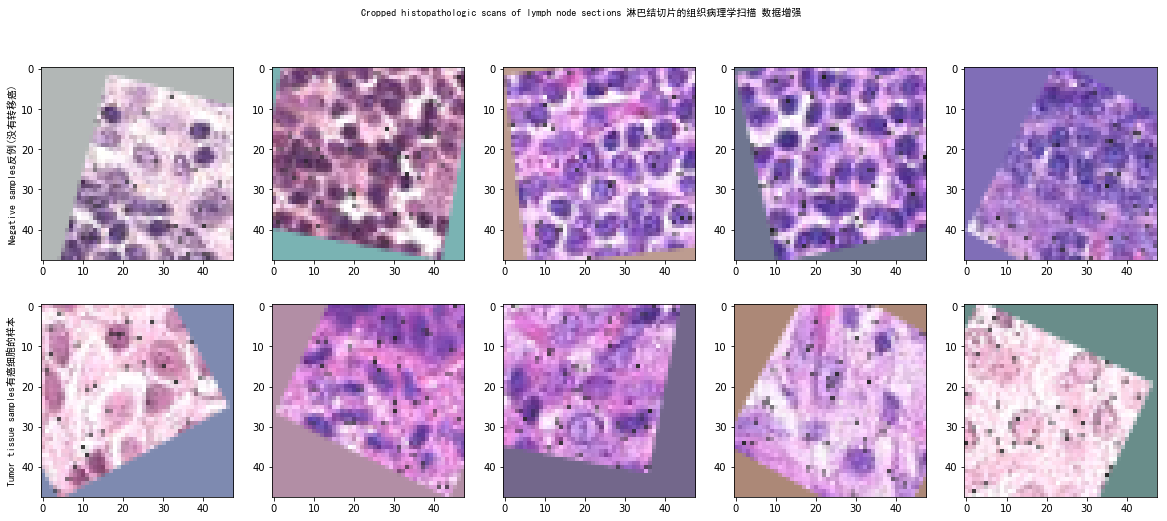

In [89]:
# 展示数据增强后的图片

# matpoltlib subplots :创建一系列的子图  nrows子图行的个数，ncols子图列的个数 ,figsize画布尺寸, axes子图的轴， fig图
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections 淋巴结切片的组织病理学扫描 数据增强',fontsize=20,fontproperties=myfont) # 标题
# Negatives 反例(没有转移癌)
imgs=augment_images(f['train_images7'][sorted(ndata[0:5])],(48, 48))
for i in range(5): 
#     print(np.max(imgs[i]),np.min(imgs[i]))
    ax[0,i].imshow(imgs[i]) # idx是随机排列的前五个反例的图片名，i是0~4的索引
ax[0,0].set_ylabel('Negative samples反例(没有转移癌)', size='large',fontproperties=myfont) # 给坐标为[0,0]的轴画出其y轴标题
imgs=augment_images(f['train_images7'][sorted(pdata[0:5])],(48, 48))
for i in range(5):
#     print(np.max(imgs[i]),np.min(imgs[i]))
    ax[1,i].imshow(imgs[i])
ax[1,0].set_ylabel('Tumor tissue samples有癌细胞的样本', size='large',fontproperties=myfont) # 给坐标为[1,0]的轴画出其y轴标题

**To see the effects of our augmentation, we can plot one image multiple times要查看我们的增强效果，我们可以多次绘制一幅图像.**

In [100]:
ndata[0:1]

[7657]

In [111]:
img=f['train_images7'][sorted(ndata[0:1])]
print(augment_images(img,(48,48)).shape)

(1, 48, 48, 3)


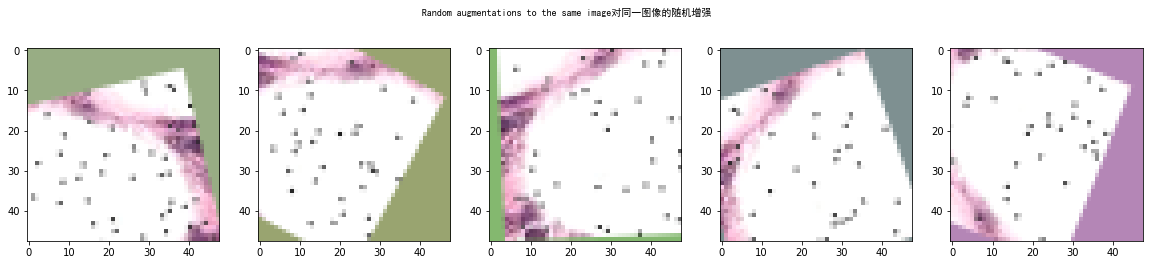

In [113]:
# 同一图像随机增强五次，看效果

# matpoltlib subplots :创建一系列的子图  nrows子图行的个数，ncols子图列的个数 ,figsize画布尺寸, axes子图的轴， fig图
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random augmentations to the same image对同一图像的随机增强',fontsize=20,fontproperties=myfont) # 标题
# Negatives 反例(没有转移癌)
# for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]): # idx是随机排列的第一个反例的图片名，i是索引0
for j in range(5): # 同一图像随机增强五次，看效果
    ax[j].imshow(augment_images(f['train_images7'][sorted(ndata[0:1])],(48, 48))[0])

## Compute image statistics计算图像数据的统计信息
**Do not use augmentation here!在这里不使用数据增强**

Calculating statistics will give channel averages of [0.702447, 0.546243, 0.696453] (图像每个通道的平均值),
and std's of [0.238893, 0.282094, 0.216251] (图像每个通道的方差).

While we are calculating statistics, we can check if there are images that have a very low maximum pixel intensity (almost totally black) or very high minimum pixel intensity (almost totally white). These kind of images could be caused by bad exposure or cropping to an empty area. In case of an empty area, the image would not be an outlier but equally valid negative sample.  
在我们计算统计数据的同时，我们可以检查是否存在具有最大像素值非常低的（几乎全黑）或最小像素值非常高的（几乎全白）的图像。 这些图像可能是由于曝光不良或裁剪到空白区域造成的。 在空白区域的情况下，图像不是异常值，而是同样有效的负样本。  

We find that there is at least one very dark and 6 very bright images.  
我们发现至少有一个非常暗的图像和6个非常明亮的图像。

In [10]:
print("julyedu")

julyedu


In [11]:
# 计算图像每个通道的平均值和方差，并找出异常图片。
# fan:如果明白了这个环节的内容并想不运行下面耗时的代码，可以直接令：
channel_avr = [0.70244707, 0.54624322, 0.69645334]
channel_std = [0.23889325, 0.28209431, 0.21625058]
too_dark_idx = ['9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
too_bright_idx = ['c448cd6574108cf14514ad5bc27c0b2c97fc1a83', '9071b424ec2e84deeb59b54d2450a6d0172cf701', 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b', '5a268c0241b8510465cb002c4452d63fec71028a', '5f30d325d895d873d3e72a82ffc0101c45cba4a8', '54df3640d17119486e5c5f98019d2a92736feabc']
# 这样可以不用运行求均值、方差的代码 继续学习后面环节的代码，而不报错。

# # As we count the statistics, we can check if there are any completely black or white images 在统计数据时，我们可以检查是否有完全黑色或白色的图像
# dark_th = 10 / 255      # If no pixel reaches this threshold, image is considered too dark 如果一张图片所有像素都低于此阈值，则图像被认为太暗
# bright_th = 245 / 255   # If no pixel is under this threshold, image is considerd too bright 如果一张图片所有像素都高于此阈值，则认为图像太亮
# too_dark_idx = [] # 太暗图片的名字列表
# too_bright_idx = []  # 太亮图片的名字列表

# x_tot = np.zeros(3)
# x2_tot = np.zeros(3)
# counted_ones = 0
# for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'): # tqdm_notebook可用于显示进度条，其第二个参数是提示用的
#     path = os.path.join(train_path, idx) # 将训练集路径与反例图片名 拼接起来
#     # 执行自定义的函数，不做数据增强，但做归一化，并将图像的形状从(96,96,3) 转成 (9216,3)
#     imagearray = readCroppedImage(path + '.tif', augmentations = False).reshape(-1,3) 
    
#     # is this too dark 如果图像太暗了
#     if(imagearray.max() < dark_th): # 如果图像像素值最大的也比 设定的最小阈值小
#         too_dark_idx.append(idx) # 把这张图片的名字记录在小本本上
#         continue # do not include in statistics 跳过本次循环，不将其纳入后面的求平均、求方差
    
#     # is this too bright 如果图像太亮了
#     if(imagearray.min() > bright_th): # 如果图像像素值最小的也比 设定的最大阈值大
#         too_bright_idx.append(idx) # 把这张图片的名字记录在小本本上
#         continue # do not include in statistics 跳过本次循环，不将其纳入后面的求平均、求方差
    
#     # 统计 ： 用于数据的标准化
#     x_tot += imagearray.mean(axis=0) # 每个样本的 对应通道的像素值的平均值之和 最后维度是(3,)
#     x2_tot += (imagearray**2).mean(axis=0) # 每个样本的 对应通道的像素值的平方的平均值之和  最后维度是(3,)
#     counted_ones += 1 # 正常图片的个数
    
# channel_avr = x_tot/counted_ones #每个通道的像素值平均值 最后维度是(3,)
# # 这一步是计算[E(x)]^2
# channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2) #每个通道的像素值标准差 最后维度是(3,)
# # 方差公式：D(X) = E(X^2) - [E(x)]^2
# channel_avr,channel_std
# # (array([0.70244707, 0.54624322, 0.69645334]),
# #  array([0.23889325, 0.28209431, 0.21625058]))

In [12]:
print('There was {0} extremely dark image'.format(len(too_dark_idx))) # 太暗的图像的个数
print('and {0} extremely bright images'.format(len(too_bright_idx))) # 太亮的图像的个数
print('Dark one:') 
print(too_dark_idx) # 打印太暗图片的名字
print('Bright ones:') # 打印太亮图片的名字
print(too_bright_idx) 

There was 1 extremely dark image
and 6 extremely bright images
Dark one:
['9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
Bright ones:
['c448cd6574108cf14514ad5bc27c0b2c97fc1a83', '9071b424ec2e84deeb59b54d2450a6d0172cf701', 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b', '5a268c0241b8510465cb002c4452d63fec71028a', '5f30d325d895d873d3e72a82ffc0101c45cba4a8', '54df3640d17119486e5c5f98019d2a92736feabc']


## Plot some of the very bright or very dark images看看这些太亮和太暗的图片

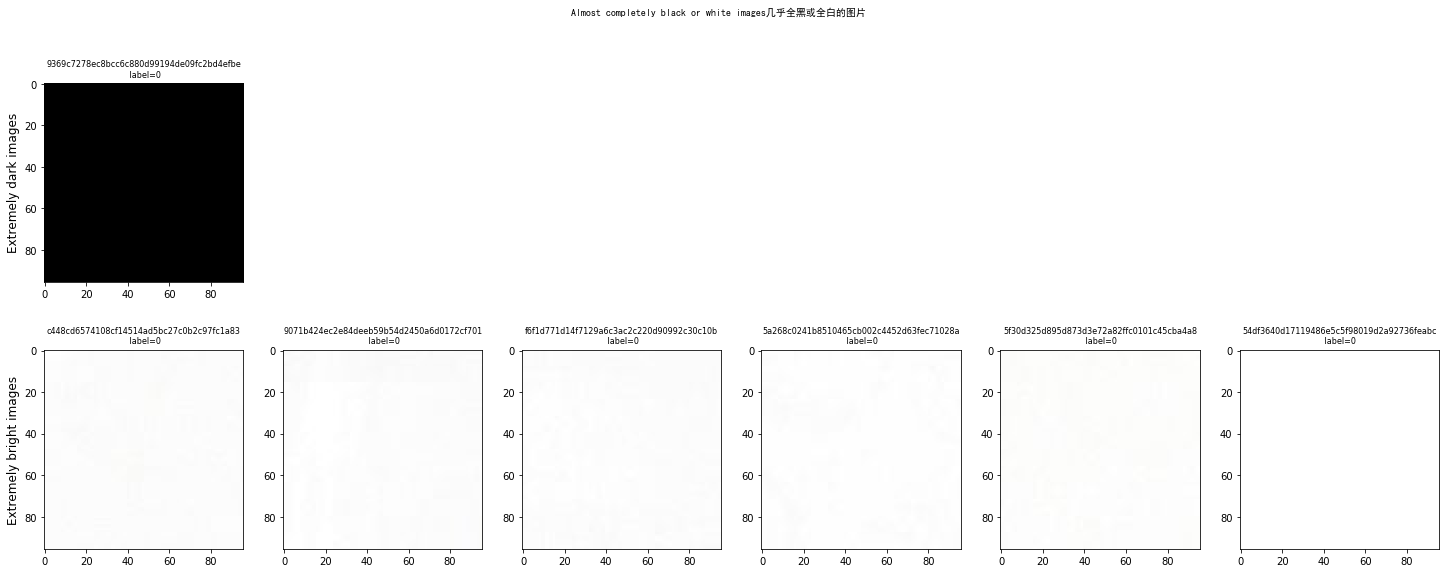

In [13]:
# 展示异常图片

fig, ax = plt.subplots(2,6, figsize=(25,9))
# matpoltlib subplots :创建一系列的子图  nrows子图行的个数，ncols子图列的个数 ,figsize画布尺寸, axes子图的轴， fig图
fig.suptitle('Almost completely black or white images几乎全黑或全白的图片',fontsize=20,fontproperties=myfont) # 标题

# Too dark 展示全局太暗的图片
i = 0
for idx in np.asarray(too_dark_idx)[:min(6, len(too_dark_idx))]: # 遍历太暗的图像 最多只展示6张图片，多了会使图片太小不好看
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0] # 太暗的图像的标记0或1
    path = os.path.join(train_path, idx) # 将训练集路径与图片名 拼接起来
    ax[0,i].imshow(readCroppedImage(path + '.tif', augmentations = False)) # 在[0,i]子图处 展示这张图片，不使用图像增强
    ax[0,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8) # 给坐标为(0,i)子图设置标题
    i += 1 
ax[0,0].set_ylabel('Extremely dark images', size='large') # 给坐标为(0,0)图像设置y轴标题
for j in range(min(6, len(too_dark_idx)), 6): # 原画布一行是6个子图，不满6个的子图不应显示
    ax[0,j].axis('off') # hide axes if there are less than 6 # 让这些没有图片的轴不显示
    
# Too bright 展示全局太亮的图片
i = 0
for idx in np.asarray(too_bright_idx)[:min(6, len(too_bright_idx))]: # 遍历太亮的图像 最多只展示6张图片，多了图片太小不好看了
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0] # 太亮的图像的标记
    path = os.path.join(train_path, idx) # 将训练集路径与图片名 拼接起来
    ax[1,i].imshow(readCroppedImage(path + '.tif', augmentations = False)) # 展示这张图片，不使用图像增强
    ax[1,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8) # 给坐标为(0,i)图像设置标题
    i += 1
ax[1,0].set_ylabel('Extremely bright images', size='large') # 给坐标为(1,0)图像设置y轴标题
for j in range(min(6, len(too_bright_idx)), 6): # 遍历没有图像的轴(当然这里太亮的图片数量刚好是6，range(6,6)就不用遍历了)
    ax[1,j].axis('off') # hide axes if there are less than 6 # 让这些没有图片的轴不显示

In [14]:
print("julyedu")

julyedu


All the dark and bright images are labeled negative. I think the bright ones are just cropped from a non-stained part or they don't have any tissue (plain glass?) so the labels are correct. The samples don't have tumor tissue present. I am not so sure about the dark image, is it an outlier crop from badly exposed area or just some very large cell part filling the whole image. Anyway, removing only a small amount of outliers from this size data set has little or no effect on the prediction performance.  
对异常图片的分析：所有过于黑暗和明亮的图像都标记为反例样本。 我认为明亮的那些只是从未染色的部分裁剪或他们没有任何组织（普通玻璃？）所以反例标记是正确的，即样本不存在肿瘤组织。 我不太确定黑暗的图像，它是来自暴露严重区域的异常剪切，还是只是填充整个图像的一些非常大的细胞部分。无论如何，<font color='blue'>从该大小数据集中仅去除少量异常值对预测性能几乎没有影响或没有影响。</font>  
fan:  
有些人建议保留这些异常值：  
How I drop from 0.9805 Private LB to 0.974 (113rd Solution)反思  
https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/87367#latest-504483